### Case Study : Recommendation System

#### Problem Statement:
To design and implement movie recommendation system to provide most relevant recommendations to the user

#### Input data:
1. Movies dataset
2. Users dataset
3. Ratings dataset

### Import Libraries

In [ ]:
#Import all the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix

In [ ]:
!pip install scikit-surprise

In [ ]:
# Set Global Parameters

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style('darkgrid')

In [ ]:
# Read the datasets into the pandas dataframe

df1 = pd.read_fwf('zee_movies.dat', encoding='ISO-8859-1')
df2 = pd.read_fwf('zee_users.dat', encoding='ISO-8859-1')
df3 = pd.read_fwf('zee_ratings.dat', encoding='ISO-8859-1')

In [ ]:
# Copy Dataframe to working dataframe

movies = df1.copy()
users = df2.copy()
ratings = df3.copy()

#### Perform EDA

In [ ]:
# Display shape of all the datasets

movies.shape, users.shape, ratings.shape

((3883, 3), (6040, 1), (1000209, 1))

In [ ]:
# Get the glimpse of movies dataset

movies.head()

Movie ID::Title::Genres Unnamed: 1 Unnamed: 2
0  1::Toy Story (1995)::Animation|Children's|Comedy        NaN        NaN
1   2::Jumanji (1995)::Adventure|Children's|Fantasy        NaN        NaN
2        3::Grumpier Old Men (1995)::Comedy|Romance        NaN        NaN
3         4::Waiting to Exhale (1995)::Comedy|Drama        NaN        NaN
4     5::Father of the Bride Part II (1995)::Comedy        NaN        NaN

In [ ]:
# Get the glimpse of Users dataset

users.head()

UserID::Gender::Age::Occupation::Zip-code
0                        1::F::1::10::48067
1                       2::M::56::16::70072
2                       3::M::25::15::55117
3                        4::M::45::7::02460
4                       5::M::25::20::55455

In [ ]:
# Get the glimpse of rating dataset

ratings.head()

UserID::MovieID::Rating::Timestamp
0              1::1193::5::978300760
1               1::661::3::978302109
2               1::914::3::978301968
3              1::3408::4::978300275
4              1::2355::5::978824291

In [ ]:
# Define a function for data formating and data cleaning

def func_lambda(x,i):
    if x == None:
        return None

    try:
        return x[i]
    except IndexError:
        return None
    else:
        return None

In [ ]:
# Define a function to typecast the data into integer format

def func_convertInt(x):
    try:
        return x.astype('int')
    except:
        return 0

#### Data cleaning and formatting of movies dataset

In [ ]:
# Split the raw movies dataset and prepare the dataframe with clean labels

movies['MovieID'] = movies['Movie ID::Title::Genres'].str.split('::').apply(lambda x: func_lambda(x,0))
movies['Title'] = movies['Movie ID::Title::Genres'].str.split('::').apply(lambda x: func_lambda(x,1))
movies['Genres'] = movies['Movie ID::Title::Genres'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 2)).str.split('|')

In [ ]:
# Keep the copy of the movies dataset for future use and referencing to the movie Title

movies_non_explode = movies.copy()
movies_non_explode = movies_non_explode.loc[~movies_non_explode['Genres'].isna()]
movies_non_explode = movies_non_explode[['MovieID', 'Title','Genres']]
movies_non_explode['MovieID'] = movies_non_explode['MovieID'].astype('int')

In [ ]:
# Explode the Genres label

movies = movies[['MovieID', 'Title', 'Genres']]
movies = movies.explode('Genres')

In [ ]:
# Feature engg to create Release Year label

release = movies['Title'].str.split(' ').apply(lambda x: func_lambda(x,-1))
release = release.str.split('(').apply(lambda x: func_lambda(x,-1))
release = release.str.split(')').apply(lambda x: func_lambda(x,0))
movies['ReleaseYear'] = pd.Series(release)
movies = movies.loc[movies['ReleaseYear'].str.isdigit()]

In [ ]:
# Get the glimpse of cleaned movies dataset

movies.head()

MovieID             Title      Genres ReleaseYear
0       1  Toy Story (1995)   Animation        1995
0       1  Toy Story (1995)  Children's        1995
0       1  Toy Story (1995)      Comedy        1995
1       2    Jumanji (1995)   Adventure        1995
1       2    Jumanji (1995)  Children's        1995

#### Data cleaning and formatting of users dataset

In [ ]:
# Split the raw data and format that to the necessary labels

users['UserID'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 0))
users['Gender'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 1))
users['Age'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 2))
users['Occupation'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 3))
users['Zip-code'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 4))

In [ ]:
# Prepare the final users dataframe

users = users[['UserID','Gender','Age','Occupation','Zip-code']]

In [ ]:
# Get the glimpse of cleaned users dataset

users.head()

UserID Gender Age Occupation Zip-code
0      1      F   1         10    48067
1      2      M  56         16    70072
2      3      M  25         15    55117
3      4      M  45          7    02460
4      5      M  25         20    55455

#### Data cleaning and formatting of ratings dataset

In [ ]:
# Split row ratings data into proper labels

ratings['UserID'] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::').apply(
                                                        lambda x:
                                                        func_lambda(x,0))
ratings['MovieID'] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::').apply(
                                                        lambda x:
                                                        func_lambda(x,1))
ratings['Rating'] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::').apply(
                                                        lambda x:
                                                        func_lambda(x,2))
ratings['Timestamp'] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::').apply(
                                                        lambda x:
                                                        func_lambda(x,3))

ratings['Timestamp'] = ratings['Timestamp'].astype('int')
ratings['Hour'] = ratings['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)

In [ ]:
# Prepare final ratings dataset

ratings = ratings[['UserID','MovieID','Rating','Hour']]

In [ ]:
# Get the glimpse of final ratings dataset

ratings.head()

UserID MovieID Rating  Hour
0      1    1193      5    22
1      1     661      3    22
2      1     914      3    22
3      1    3408      4    22
4      1    2355      5    23

### Missing value check and treatment

In [ ]:
## Null values check in Users dataset

users.isna().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [ ]:
## Null values check in Ratings dataset

ratings.isna().sum()

UserID     0
MovieID    0
Rating     0
Hour       0
dtype: int64

In [ ]:
## Null values check in Movies dataset

movies.isna().sum()

MovieID         0
Title           0
Genres         16
ReleaseYear     0
dtype: int64

In [ ]:
## Persentage of null values in Movies dataset

movies.isna().sum()/movies.shape[0]*100

MovieID        0.000000
Title          0.000000
Genres         0.251691
ReleaseYear    0.000000
dtype: float64

In [ ]:
# Check the null records having null values in Genres

movies.loc[movies['Genres'].isna()]

MovieID  \
197      199   
464      468   
720      729   
1134    1150   
1160    1176   
1341    1362   
1950    2019   
2522    2591   
2563    2632   
2721    2790   
3001    3070   
3133    3202   
3583    3652   
3611    3680   
3626    3695   
3817    3887   

                                                                   Title  \
197   Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964):   
464   Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995   
720   Institute Benjamenta, or This Dream People Call Human Life (1995):   
1134   Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982)   
1160   Double Life of Veronique, The (La Double Vie de Véronique) (1991)   
1341   Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (19   
1950   Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (195   
2522   Jeanne and the Perfect Guy (Jeanne et le garçon formidable) (1998   
2563   Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965   
2721   Final Conflict, The (a.k.a. Omen III: The Final Conflict) (1981):   
3001   Adventures of Buckaroo Bonzai Across the 8th Dimension, The (1984   
3133   Even Dwarfs Started Small (Auch Zwerge haben klein angefangen) (1   
3583   City of the Living Dead (Paura nella città dei morti viventi) (19   
3611   Decline of Western Civilization Part II: The Metal Years, The (19   
3626   Toxic Avenger Part III: The Last Temptation of Toxie, The (1989):   
3817   Went to Coney Island on a Mission From God... Be Back by Five (19   

     Genres ReleaseYear  
197    None        1964  
464    None        1995  
720    None        1995  
1134   None        1982  
1160   None        1991  
1341   None          19  
1950   None         195  
2522   None        1998  
2563   None        1965  
2721   None        1981  
3001   None        1984  
3133   None           1  
3583   None          19  
3611   None          19  
3626   None        1989  
3817   None          19

In [ ]:
# Drop null values as there are only 0.25% of Genre are missing

movies = movies.loc[~movies['Genres'].isna()]

In [ ]:
## Verify Movies Dataset after dropping null values

movies.isna().sum()

MovieID        0
Title          0
Genres         0
ReleaseYear    0
dtype: int64

###

### Merging all input datasets into single dataframe

In [ ]:
### Merge Movies, Users, and Ratings datasets

df = movies.merge(ratings, how='inner', on='MovieID')
df = df.merge(users, how='inner', on= 'UserID')

In [ ]:
## Get glimpse of merged single dataframe

df.head()

MovieID              Title      Genres ReleaseYear UserID Rating  Hour  \
0       1   Toy Story (1995)   Animation        1995      1      5    23   
1       1   Toy Story (1995)  Children's        1995      1      5    23   
2       1   Toy Story (1995)      Comedy        1995      1      5    23   
3      48  Pocahontas (1995)   Animation        1995      1      5    23   
4      48  Pocahontas (1995)  Children's        1995      1      5    23   

  Gender Age Occupation Zip-code  
0      F   1         10    48067  
1      F   1         10    48067  
2      F   1         10    48067  
3      F   1         10    48067  
4      F   1         10    48067

In [ ]:
# Shape of merged dataset

df.shape

(2060031, 11)

In [ ]:
# Rearrange columns and drop unwanted lables

df = df[['UserID',
         'Gender',
         'Age',
         'Occupation',
         'Zip-code',
         'MovieID',
         'Title',
         'Genres',
         'Rating',
         'Hour',
         'ReleaseYear']]

In [ ]:
# Get the glimpse of the dataset

df.head()

UserID Gender Age Occupation Zip-code MovieID              Title  \
0      1      F   1         10    48067       1   Toy Story (1995)   
1      1      F   1         10    48067       1   Toy Story (1995)   
2      1      F   1         10    48067       1   Toy Story (1995)   
3      1      F   1         10    48067      48  Pocahontas (1995)   
4      1      F   1         10    48067      48  Pocahontas (1995)   

       Genres Rating  Hour ReleaseYear  
0   Animation      5    23        1995  
1  Children's      5    23        1995  
2      Comedy      5    23        1995  
3   Animation      5    23        1995  
4  Children's      5    23        1995

### EDA and univariate/bivariate analysis

In [ ]:
# check for null values in final dataset

df.isna().sum()

UserID         0
Gender         0
Age            0
Occupation     0
Zip-code       0
MovieID        0
Title          0
Genres         0
Rating         0
Hour           0
ReleaseYear    0
dtype: int64

In [ ]:
# Get column details using dataframe info()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060031 entries, 0 to 2060030
Data columns (total 11 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   UserID       object
 1   Gender       object
 2   Age          object
 3   Occupation   object
 4   Zip-code     object
 5   MovieID      object
 6   Title        object
 7   Genres       object
 8   Rating       object
 9   Hour         int64 
 10  ReleaseYear  object
dtypes: int64(1), object(10)
memory usage: 188.6+ MB


In [ ]:
# Get Stat using dataframe describe()

df.describe()

Hour
count  2.060031e+06
mean   1.190753e+01
std    7.903594e+00
min    0.000000e+00
25%    4.000000e+00
50%    1.400000e+01
75%    1.900000e+01
max    2.300000e+01

In [ ]:
# Get categorial variable stats using describe()

df.describe(include='object')

UserID   Gender      Age Occupation Zip-code  MovieID  \
count   2060031  2060031  2060031    2060031  2060031  2060031   
unique     6040        2        7         21     3439     3682   
top        4169        M       25          4    94110     1580   
freq       3970  1563214   815051     271976     7665    10152   

                      Title   Genres   Rating ReleaseYear  
count               2060031  2060031  2060031     2060031  
unique                 3682       63        5          81  
top     Men in Black (1997)   Comedy        4        1999  
freq                  10152   353032   715225      150709

### Inference from describe()
1. Top user : 4269
2. Top Gender: Male
3. Top Age: 25
4. Top Occupation: 4
5. Top Zip-code: 94110
6. Top movie id: 1580
7. Top movie title: Men in Black(1997)
8. Top Genre: Comedy
9. Top Rating: 4
10.Top Release year: 1999

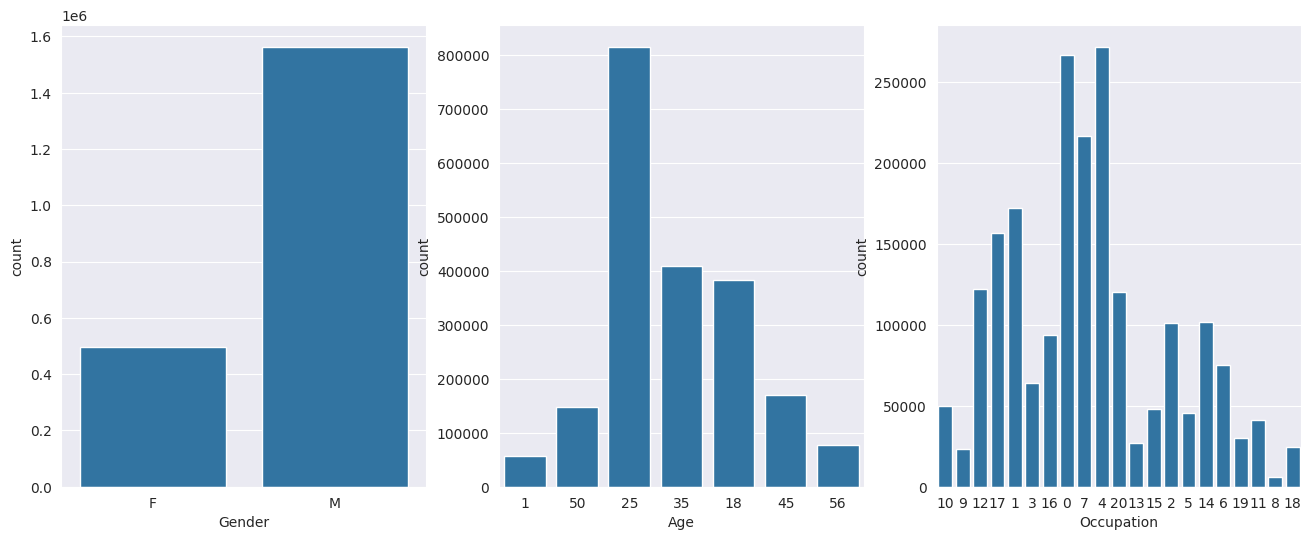

In [ ]:
# Count plot of Male and Female
# Count plot of Age
# Count plot of Occupation

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
sns.countplot(data=df, x='Gender')
plt.subplot(1,3,2)
sns.countplot(data=df, x='Age')
plt.subplot(1,3,3)
sns.countplot(data=df, x='Occupation')
plt.show()

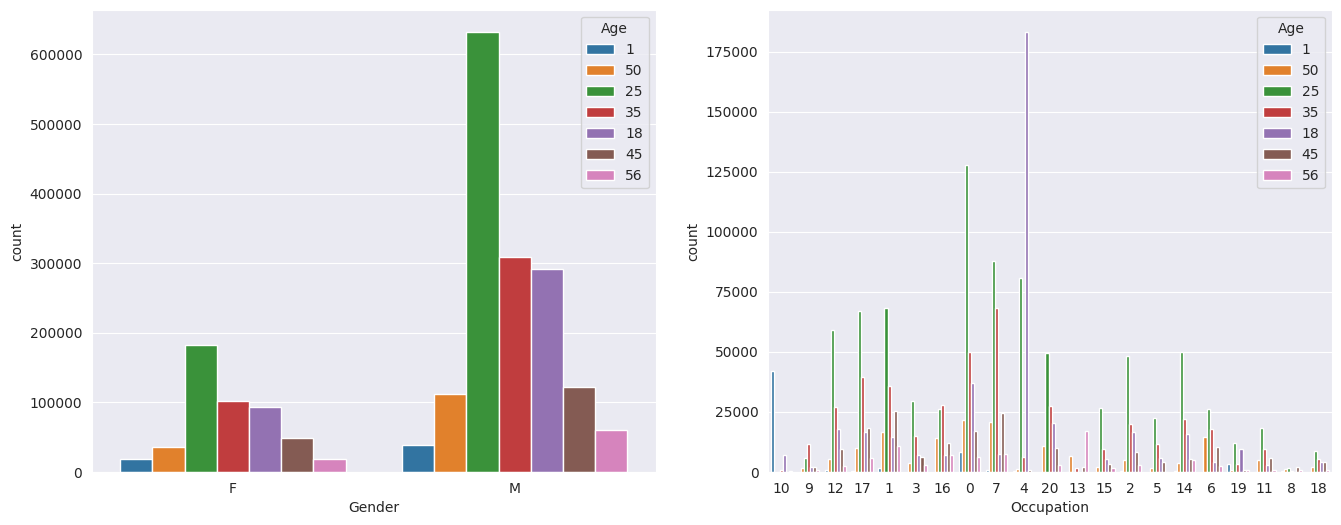

In [ ]:
# Age wise countplot w.r.t to Gender
# Age wise countplot w.r.t to Occupation

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.countplot(data=df, x='Gender', hue='Age')
plt.subplot(1,2,2)
sns.countplot(data=df, x='Occupation', hue='Age')
plt.show()

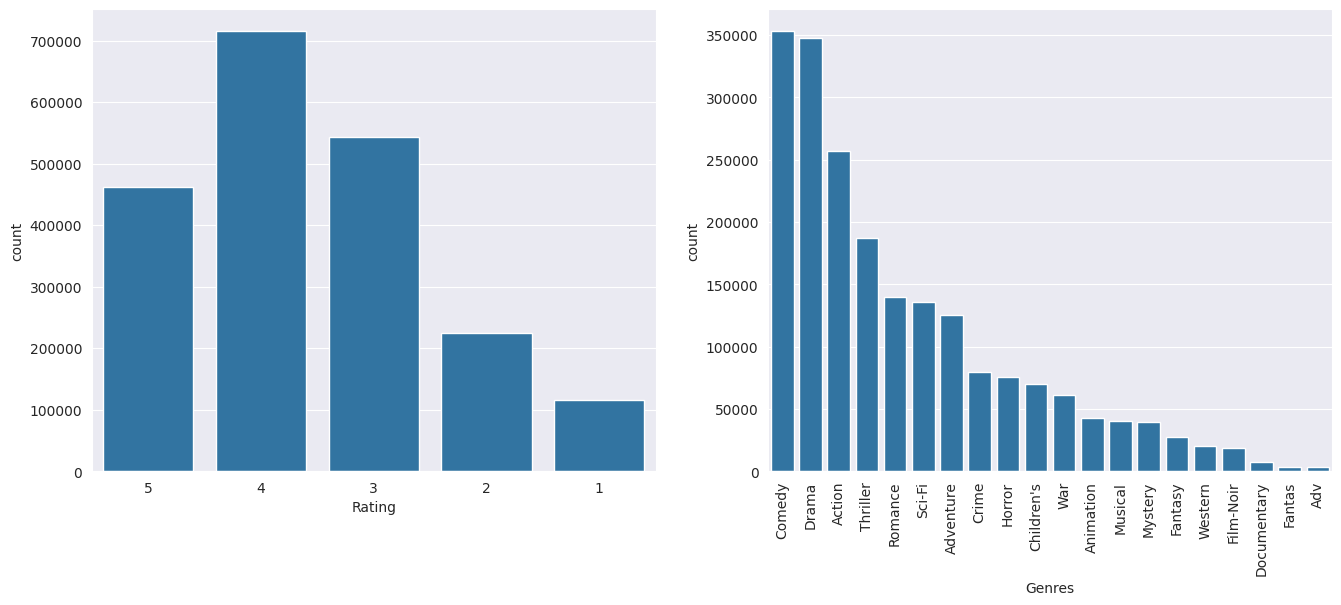

In [ ]:
# Countplot of Rating
# Countplot of Genres

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.countplot(data=df, x='Rating')
plt.subplot(1,2,2)
sns.countplot(data=df, x='Genres', order=df['Genres'].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.show()

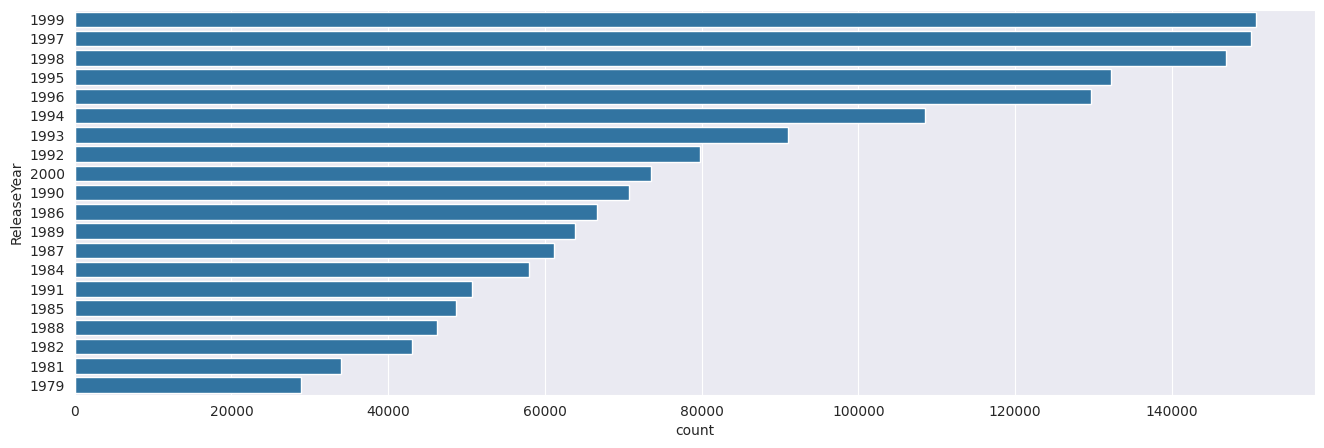

In [ ]:
# Countplot of Release Year

plt.figure(figsize=(16,5))
sns.countplot(data=df, y='ReleaseYear',
            order= df['ReleaseYear'].value_counts().iloc[:20].index)

plt.show()

<Axes: xlabel='count', ylabel='Hour'>

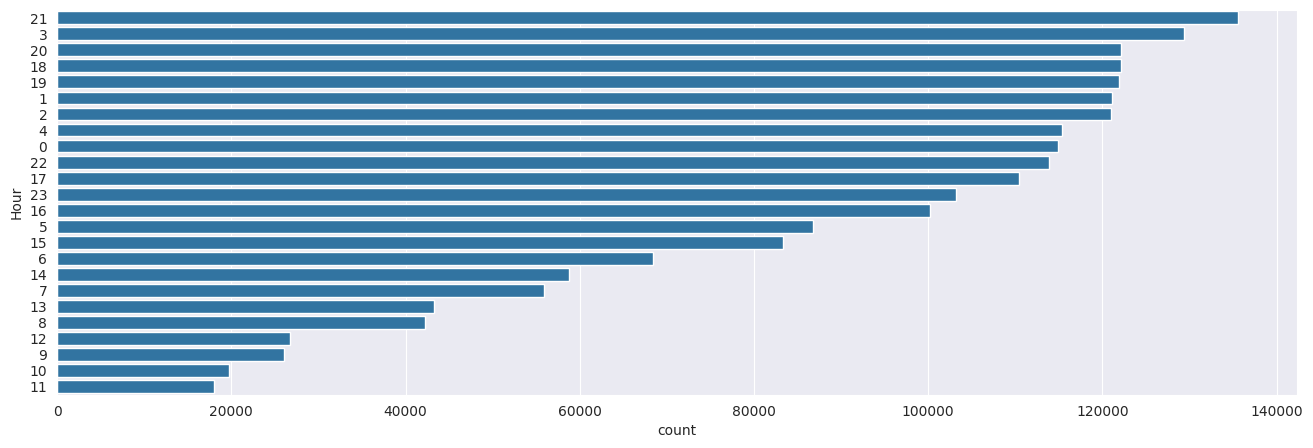

In [ ]:
# Counplot of Hours

plt.figure(figsize=(16,5))
sns.countplot(data=df, y='Hour',
             order=df['Hour'].value_counts().iloc[:].index)

In [ ]:
# Make a copy of dataframe for further monipulations and usage

dff = df.copy()
dff['Rating'] = dff['Rating'].astype('int')
dff['Age']= dff['Age'].astype('int')

### Group the data according to average rating and count rating

In [ ]:
# Group the titles with average rating and count of ratings r(eceived

ratings_titles = dff.groupby(['Title'])['Rating'].mean().reset_index()
ratings_titles = ratings_titles.merge(dff.groupby(['Title'])['Rating'].count().reset_index(), on='Title')
ratings_titles = ratings_titles.rename(columns= {'Rating_x':'Avg_Rating','Rating_y':'Count_Rating'})
ratings_titles['Avg_Rating'] = ratings_titles['Avg_Rating'].round(2)
ratings_titles

Title  Avg_Rating  Count_Rating
0                         $1,000,000 Duck (1971)        3.03            74
1                           'Night Mother (1986)        3.37            70
2                      'Til There Was You (1997)        2.69           104
3                             'burbs, The (1989)        2.91           303
4                  ...And Justice for All (1979)        3.71           398
...                                          ...         ...           ...
3677                 Zed & Two Noughts, A (1985)        3.41            29
3678                          Zero Effect (1998)        3.75           602
3679  Zero Kelvin (Kjærlighetens kjøtere) (1995)        3.50             2
3680                     Zeus and Roxanne (1997)        2.52            23
3681                             eXistenZ (1999)        3.26          1230

[3682 rows x 3 columns]

In [ ]:
# Group the user with Average rating and count of rating received

user_ratings = dff.groupby(['UserID'])['Rating'].mean().reset_index()
user_ratings = user_ratings.merge(dff.groupby(['UserID'])['Rating'].count().reset_index(), on= 'UserID')
user_ratings = user_ratings.rename(columns={'Rating_x':'Avg_Rating','Rating_y':'Count_Rating'})
user_ratings['Avg_Rating'] = user_ratings['Avg_Rating'].round(2)
user_ratings

UserID  Avg_Rating  Count_Rating
0         1        4.20           115
1        10        4.14           849
2       100        3.04           207
3      1000        4.08           214
4      1001        3.60           657
...     ...         ...           ...
6035    995        3.85           121
6036    996        3.91           689
6037    997        4.00            66
6038    998        4.07           215
6039    999        3.16           912

[6040 rows x 3 columns]

In [ ]:
# Prepare Dataset with user as index and titles as columns.
# values - Ratings given by user to that particular movie title

users_titles = dff[['UserID','Title','Rating']].drop_duplicates()
users_titles = users_titles.pivot(index='UserID', columns= 'Title', values= 'Rating')

In [ ]:
# Get glimpse of the users vs titles dataframe

users_titles.head()

Title   $1,000,000 Duck (1971)  'Night Mother (1986)  \
UserID                                                 
1                          NaN                   NaN   
10                         NaN                   NaN   
100                        NaN                   NaN   
1000                       NaN                   NaN   
1001                       NaN                   NaN   

Title   'Til There Was You (1997)  'burbs, The (1989)  \
UserID                                                  
1                             NaN                 NaN   
10                            NaN                 4.0   
100                           NaN                 NaN   
1000                          NaN                 NaN   
1001                          NaN                 NaN   

Title   ...And Justice for All (1979)  1-900 (1994)  \
UserID                                                
1                                 NaN           NaN   
10                                NaN           NaN   
100                               NaN           NaN   
1000                              NaN           NaN   
1001                              NaN           NaN   

Title   10 Things I Hate About You (1999)  101 Dalmatians (1961)  \
UserID                                                             
1                                     NaN                    NaN   
10                                    NaN                    NaN   
100                                   NaN                    NaN   
1000                                  NaN                    4.0   
1001                                  NaN                    NaN   

Title   101 Dalmatians (1996)  12 Angry Men (1957)  13th Warrior, The (1999)  \
UserID                                                                         
1                         NaN                  NaN                       NaN   
10                        NaN                  3.0                       4.0   
100                       NaN                  NaN                       NaN   
1000                      NaN                  NaN                       NaN   
1001                      3.0                  NaN                       NaN   

Title   187 (1997)  2 Days in the Valley (1996)  20 Dates (1998)  \
UserID                                                             
1              NaN                          NaN              NaN   
10             NaN                          NaN              NaN   
100            NaN                          NaN              NaN   
1000           NaN                          NaN              NaN   
1001           NaN                          NaN              NaN   

Title   20,000 Leagues Under the Sea (1954)  200 Cigarettes (1999)  \
UserID                                                               
1                                       NaN                    NaN   
10                                      4.0                    NaN   
100                                     NaN                    NaN   
1000                                    NaN                    NaN   
1001                                    NaN                    1.0   

Title   2001: A Space Odyssey (1968)  2010 (1984)  \
UserID                                              
1                                NaN          NaN   
10                               3.0          NaN   
100                              4.0          NaN   
1000                             NaN          NaN   
1001                             NaN          NaN   

Title   24 7: Twenty Four Seven (1997)  24-hour Woman (1998)  28 Days (2000)  \
UserID                                                                         
1                                  NaN                   NaN             NaN   
10                                 NaN                   NaN             NaN   
100                                NaN                   NaN             NaN   
1000                               NaN     

In [ ]:
users_titles.shape

(6040, 3682)

## Imputation

In [ ]:
# perform knn imputation to treat the missing values in users_titles dataset

knn = KNNImputer(n_neighbors=5)
users_titles_imputed = knn.fit_transform(users_titles)

In [ ]:
# Form the dataframe after imputation with proper index and columns

users_titles_imputed_df = pd.DataFrame(users_titles_imputed,
                                      columns=users_titles.columns,
                                      index=users_titles.index)

In [ ]:
# get the glimpse of imputed dataset

users_titles_imputed_df.head()

Title   $1,000,000 Duck (1971)  'Night Mother (1986)  \
UserID                                                 
1                          3.0                   4.0   
10                         3.6                   3.8   
100                        2.6                   3.8   
1000                       3.0                   4.2   
1001                       2.6                   3.8   

Title   'Til There Was You (1997)  'burbs, The (1989)  \
UserID                                                  
1                             3.2                 2.6   
10                            2.8                 4.0   
100                           2.4                 3.4   
1000                          3.4                 2.8   
1001                          2.0                 2.6   

Title   ...And Justice for All (1979)  1-900 (1994)  \
UserID                                                
1                                 4.6           2.5   
10                                4.4           2.5   
100                               3.8           2.5   
1000                              4.0           2.5   
1001                              4.0           2.5   

Title   10 Things I Hate About You (1999)  101 Dalmatians (1961)  \
UserID                                                             
1                                     4.2                    4.0   
10                                    4.2                    4.6   
100                                   3.8                    4.2   
1000                                  2.4                    4.0   
1001                                  4.0                    4.0   

Title   101 Dalmatians (1996)  12 Angry Men (1957)  13th Warrior, The (1999)  \
UserID                                                                         
1                         3.8                  4.6                       2.8   
10                        4.2                  3.0                       4.0   
100                       3.4                  4.4                       2.8   
1000                      2.6                  4.2                       3.6   
1001                      3.0                  3.8                       3.4   

Title   187 (1997)  2 Days in the Valley (1996)  20 Dates (1998)  \
UserID                                                             
1              2.6                          2.8              3.2   
10             3.8                          3.4              3.6   
100            3.0                          3.8              2.6   
1000           4.0                          3.4              2.2   
1001           3.2                          3.8              3.8   

Title   20,000 Leagues Under the Sea (1954)  200 Cigarettes (1999)  \
UserID                                                               
1                                       3.4                    3.0   
10                                      4.0                    2.4   
100                                     3.6                    3.2   
1000                                    3.8                    2.0   
1001                                    3.8                    1.0   

Title   2001: A Space Odyssey (1968)  2010 (1984)  \
UserID                                              
1                                4.6          4.2   
10                               3.0          4.8   
100                              4.0          3.0   
1000                             4.4          3.8   
1001                             4.4          2.8   

Title   24 7: Twenty Four Seven (1997)  24-hour Woman (1998)  28 Days (2000)  \
UserID                                                                         
1                                  4.0                   2.0             2.6   
10                                 4.0                   2.2             3.2   
100                                4.0                   1.6             2.8   
1000                               4.0     

In [ ]:
# calculate correlation datafram from imputed datafram.

users_titles_corr = users_titles_imputed_df.corr()

#### Define function to get recommendation based on pearson correlation

In [ ]:
# Function to get recommendations based on pearson correlation
# input parameter to function - Title, correlation dataframe, number of recommendations

def pearson_corr_recommend(title, df_corr, top=5):
    movies_recom = df_corr[title].sort_values(ascending = False).head(top+1).index.to_list()[1:]
    return movies_recom

In [ ]:
# Get the recommendations for the movie "Toy Story (1995)"

m_title = 'Toy Story (1995)'
m_top = 5

print('Getting top {} recommendation for movie title {}'.format(m_top,m_title))
result = pearson_corr_recommend(m_title,users_titles_corr,5)
print('_'*80)
print('Recommended movies are...')

for i in range(len(result)):
    print('{}.{}'.format(i+1, result[i]))

Getting top 5 recommendation for movie title Toy Story (1995)
________________________________________________________________________________
Recommended movies are...
1.Toy Story 2 (1999)
2.Bug's Life, A (1998)
3.Marcello Mastroianni: I Remember Yes, I Remember (1997)
4.Aladdin (1992)
5.Air Bud (1997)


In [ ]:
# Get the recommendation for the movie "Absolute Power (1997)"


m_title = 'Absolute Power (1997)'
m_top = 5

print('Getting top {} recommendation for movie title {}'.format(m_top,m_title))
result = pearson_corr_recommend(m_title,users_titles_corr,5)
print('_'*80)
print('Recommended movies are...')

for i in range(len(result)):
    print('{}.{}'.format(i+1, result[i]))

Getting top 5 recommendation for movie title Absolute Power (1997)
________________________________________________________________________________
Recommended movies are...
1.Air Force One (1997)
2.Addams Family, The (1991)
3.52 Pick-Up (1986)
4.Perfect Murder, A (1998)
5.Adventures of Milo and Otis, The (1986)


In [ ]:
# Get the recommendation for the movie "Liar Liar"


m_title = 'Liar Liar (1997)'
m_top = 5

print('Getting top {} recommendation for movie title {}'.format(m_top,m_title))
result = pearson_corr_recommend(m_title,users_titles_corr,5)
print('_'*80)
print('Recommended movies are...')

for i in range(len(result)):
    print('{}.{}'.format(i+1, result[i]))

Getting top 5 recommendation for movie title Liar Liar (1997)
________________________________________________________________________________
Recommended movies are...
1.Jury Duty (1995)
2.Shadow Conspiracy (1997)
3.Billy Madison (1995)
4.Multiplicity (1996)
5.Distinguished Gentleman, The (1992)


#### Inference from pearson correlation
1. Pearson correlation seems to be pretty good with KNN inputation
2. Recommendation for the movie 'Toy Stoty (1995)' makes perfect sense
3. Recommendation for the movie 'Absolute Power (1997)" makes perfect sense
4. Recommendation for the movie 'Liar Liar (1997)' makes perfect sense

#### Cosine Similarity

#### Prepare user similarity matrix

In [ ]:
# Prepare new working dataset for user
# Encode categorical variables - Gender
# Typecast the numeric variable to integer
# Format the zip code

u = users.copy()
u['Gender'] = u['Gender'].map({'M':1,'F':0})
u['UserID'] = u['UserID'].astype('int')
u['Age'] = u['Age'].astype('int')
u['Occupation'] = u['Occupation'].astype('int')
u['Zip-code'] = u['Zip-code'].str.split('-').apply(lambda x: x[0])
u['Zip-code'] = u['Zip-code'].astype('int')
u.head()

UserID  Gender  Age  Occupation  Zip-code
0       1       0    1          10     48067
1       2       1   56          16     70072
2       3       1   25          15     55117
3       4       1   45           7      2460
4       5       1   25          20     55455

In [ ]:
# Prepare new working dataset of ratings
# Typecast the numeric variables to integer

r = ratings.copy()
r['UserID']= r['UserID'].astype('int')
r['MovieID']= r['MovieID'].astype('int')
r['Rating']= r['Rating'].astype('int')
r['Hour']= r['Hour'].astype('int')
r.head()

UserID  MovieID  Rating  Hour
0       1     1193       5    22
1       1      661       3    22
2       1      914       3    22
3       1     3408       4    22
4       1     2355       5    23

In [ ]:
# Prepare the combine dataframe of users with all the necessary labels to define an user
# Here labels used are - Gender, Age, Occupation, Zip-code, Avg Ratings and hours

user_cosine = u.merge(r.groupby('UserID').Rating.mean().reset_index(), on='UserID')
user_cosine = user_cosine.merge(r.groupby('UserID').Hour.mean().reset_index(), on='UserID')

In [ ]:
# Get the glimpse of users dataset for finding user similarity matrix

user_cosine.head()

UserID  Gender  Age  Occupation  Zip-code    Rating       Hour
0       1       0    1          10     48067  4.188679  22.245283
1       2       1   56          16     70072  3.713178  21.155039
2       3       1   25          15     55117  3.901961  21.000000
3       4       1   45           7      2460  4.190476  20.000000
4       5       1   25          20     55455  3.146465   6.015152

##### Perform standardization of data

In [ ]:
# Standardize the data as the metric used will be distance to find the similarity

scaler = StandardScaler()
user_cosine_scaled = pd.DataFrame(scaler.fit_transform(user_cosine),
                                 columns=user_cosine.columns,
                                 index=user_cosine.index)

In [ ]:
# Get the glimpse of stadardized data

user_cosine_scaled.head()

UserID    Gender       Age  Occupation  Zip-code    Rating      Hour
0 -1.731764 -1.591927 -2.298525    0.292803 -0.015901  1.131261  1.414540
1 -1.731191  0.628170  1.966729    1.240822 -0.007048  0.024380  1.261846
2 -1.730617  0.628170 -0.437323    1.082819 -0.013065  0.463832  1.240132
3 -1.730043  0.628170  1.113678   -0.181207 -0.034250  1.135444  1.100078
4 -1.729470  0.628170 -0.437323    1.872834 -0.012929 -1.294827 -0.858566

#### Define function to get cosine distance

In [ ]:
# Define a function to calculate cosine distance
# Input parameters - dataframe rows of two users whose cosine distance to be calculated

def cosine_distance(x,y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

##### Consider only top users
1. Calculating the similarity matrix of all the users is very time consuming and memory in-efficient in this case
2. Hence, we are considering only those users who has provied more than 1000 count of ratings
3. Number of such users comes out to be around 400

In [ ]:
# Get the count of those users who has provided more than 1000 count of ratings

user_ratings.loc[user_ratings['Count_Rating']>1000].shape

(403, 3)

In [ ]:
# Consider only those users who has provided more than 1000 count of ratings

users_considered = user_ratings.loc[user_ratings['Count_Rating']>1000]['UserID'].values.astype('int')
users_considered[:10]

array([1004, 1010, 1015, 1019, 1050, 1051, 1068, 1069, 1088, 1100])

In [ ]:
# Prepare user similarity matrix of only top users who has provided more than 1000 count of ratings

user_similarity_matrix = pd.DataFrame(columns=users_considered)
for i in users_considered:
    for j in users_considered:
        user_similarity_matrix.loc[i,j] = cosine_distance(user_cosine_scaled.loc[i],
                                                          user_cosine_scaled.loc[j])

In [ ]:
# Get the glimpse of user_similarity matrix

user_similarity_matrix.head()

1004      1010      1015      1019      1050      1051      1068  \
1004       1.0  0.773311  0.306127  0.489597  -0.03844  0.452912  0.313202   
1010  0.773311       1.0 -0.154565  0.315472  0.293272  0.311347   0.59957   
1015  0.306127 -0.154565       1.0  0.328436 -0.406361 -0.128111  0.115631   
1019  0.489597  0.315472  0.328436       1.0 -0.333441 -0.143287  0.462767   
1050  -0.03844  0.293272 -0.406361 -0.333441       1.0  0.659914  0.012264   

          1069      1088      1100      1101      1112      1117      1120  \
1004  0.312839  0.156873 -0.169268 -0.452039  0.269032  0.218343  0.356544   
1010   0.39564  -0.18093 -0.020193  0.034839  0.302966 -0.171508 -0.090658   
1015 -0.054681  0.593299  0.283851 -0.103959 -0.080529  0.980045  0.852849   
1019 -0.404829  0.266832 -0.213712 -0.147538  0.386173  0.287122 -0.013682   
1050   0.77185 -0.141233  0.257626   0.32249  0.174984 -0.346051 -0.189734   

          1125      1137      1150      117       1181      1194      1202  \
1004  0.445256   0.59375  0.799025  0.528866  0.121457 -0.259613 -0.244108   
1010  0.013262  0.801832  0.822563  0.254901   0.56031 -0.106545 -0.133284   
1015  0.973702 -0.055042  0.164922  0.778302 -0.401356 -0.294521 -0.202788   
1019   0.31912  0.746653  0.757092  0.791017  0.526418  0.391053 -0.224924   
1050 -0.379333   0.07859 -0.070791 -0.247339   0.22341  0.441169  0.831554   

          1203      1207      1224      123       1242      1244      1246  \
1004 -0.185954  0.027609  0.291226  0.752822  0.253406  0.485611  0.129757   
1010 -0.119408 -0.057991 -0.171843  0.375304  0.010025  0.069663  0.069113   
1015  0.328813  0.089122  0.792822  0.660399  0.824133  0.491797  0.252345   
1019  0.317501  0.054874  0.157495  0.087181  0.685614  0.881695 -0.179733   
1050  0.000815   0.13825 -0.229706  0.001381 -0.383227 -0.436131  0.222908   

          1264      1266      1274      1284      1285      1297      1298  \
1004 -0.127322  0.289698  0.744205  0.791377  0.612753  0.370056  0.801531   
1010  0.021886  0.235682   0.17408  0.760583  0.575774   0.13854  0.809806   
1015  0.063194  0.495804  0.751425  0.126922  0.522079  0.596862  0.180229   
1019  0.484948  0.872219   0.50246   0.03246  0.638628  0.235387  0.790754   
1050  0.282506 -0.281941 -0.427241   0.25662 -0.212297  -0.03392 -0.095097   

          1303      1317      1333      1340      1354      1377      1383  \
1004  0.875984   0.27836  0.751367 -0.043464  0.399397  0.614233  0.535778   
1010  0.799729  0.654813  0.471624  0.534077 -0.028009  0.338091  0.921747   
1015  0.153006 -0.056551  0.574975 -0.258857  0.529944  0.064664 -0.288679   
1019  0.775037  0.500051   -0.0226 -0.020268   0.40571 -0.043599  0.391984   
1050 -0.114995  0.079025 -0.017979  0.358292  0.027045  0.397513  0.253611   

          1422      1425      1447      1448      1449      1451      1465  \
1004  0.106178  0.181278 -0.283557 -0.130452  0.106815  0.090985 -0.200163   
1010 -0.140412  0.343429 -0.253129 -0.055209  0.691656  -0.41683 -0.057585   
1015  0.226797   0.16416 -0.134826  0.548657 -0.390951  0.686089 -0.004796   
1019  0.286038  0.817627 -0.135828  0.413897 -0.025323  0.055811  0.241671   
1050 -0.078458 -0.139006  0.731539 -0.250538  0.453295   0.04014  0.109166   

          1470      148       149       1496      1501      151       1579  \
1004  0.186302  0.384909  0.865686  0.185699  0.016881   0.14309  -0.35672   
1010 -0.062375  0.403044  0.688393 -0.197942  0.484713    0.0243 -0.106093   
1015  0.568021  0.073563  0.397216  0.772199 -0.297115  0.168865 -0.354615   
1019  0.873803   0.17815  0.385028 -0.100378  0.145733   0.41071 -0.080969   
1050 -0.453714  0.353996  0.172394 -0.160098  0.374301  0.085977  0.810705   

          1587      1599      1605      1611      1613      163       1632  \
1004  0.569432  0.225638 -0.153115  0.358124 -0.047278  0.429224 -0.200643   
1010  0.229151  0.368514 -0.221167   0.26262  0.188998 -0.058586  -0.00913   
1015  0.348025  0.477818

#### user based recommended based on cosine similarity matrix

In [ ]:
# Define a function to get user based recommendation based on cosine similarity matrix
# Input parameters to function - userid, users dataframe, number of recommendations needed

def user_similarity_recommended(userid,cosine_df, top=5):
    temp = pd.DataFrame(columns=cosine_df.index)
    for i in cosine_df.index:
        temp.loc[userid,i] = cosine_distance(cosine_df.loc[userid],cosine_df.loc[i])
    return temp.loc[userid].sort_values(ascending=False).head(top+1).index.to_list()[1:]

In [ ]:
# Get the user recommendations for user id based on cosine similarity

u_id = 1
n_top = 5

print('Getting top {} recommendations for user id {}'.format(n_top,u_id))

result = user_similarity_recommended(u_id, user_cosine_scaled, n_top)

print('-'*80)
print('Recommended users are...')
for i in range(len(result)):
    print('{}.{}'.format(i+1,result[i]))

Getting top 5 recommendations for user id 1
--------------------------------------------------------------------------------
Recommended users are...
1.580
2.723
3.286
4.1117
5.1015


#### Inference from user based cosine similarity
1. User based recommendation works well based on cosine distance
2. Recommendations obtained for user id 1 are similar users - 580, 286, 457, 867, 1198
3. Parameters that we used to calculate if the users are similar or not are - Age, gender, Occupation, zip-code, rating count, hour

#### Cosine Similarity - Item-item similarity matrix

In [ ]:
# Get the glimpse of ratings dataset

r.head()

UserID  MovieID  Rating  Hour
0       1     1193       5    22
1       1      661       3    22
2       1      914       3    22
3       1     3408       4    22
4       1     2355       5    23

In [ ]:
# Make a copy of movies dataset for further workings

m = movies.copy()
m['MovieID'] = m['MovieID'].astype('int')
m = m[['MovieID','Genres','Title']]

In [ ]:
# Get the glimpse of movies dataset

m.head()

MovieID      Genres             Title
0        1   Animation  Toy Story (1995)
0        1  Children's  Toy Story (1995)
0        1      Comedy  Toy Story (1995)
1        2   Adventure    Jumanji (1995)
1        2  Children's    Jumanji (1995)

In [ ]:
# Prepare the pivot of movies dataset with index as movieID and columns as genres
# Values are 1 or 0 based on movie category

m = m.pivot(index='MovieID',columns='Genres',values='Title')
m = ~m.isna()
m = m.astype(int)
#m = m.reset_index().drop([np.nan,''],axis=1)

In [ ]:
# Get the glimpse of the pivoted dataset

m.head()

Genres      A  Acti  Action  Adv  Advent  Adventu  Adventur  Adventure  \
MovieID                                                                  
1        0  0     0       0    0       0        0         0          0   
2        0  0     0       0    0       0        0         0          1   
3        0  0     0       0    0       0        0         0          0   
4        0  0     0       0    0       0        0         0          0   
5        0  0     0       0    0       0        0         0          0   

Genres   Animati  Animation  Chi  Chil  Childr  Childre  Children  Children'  \
MovieID                                                                        
1              0          1    0     0       0        0         0          0   
2              0          0    0     0       0        0         0          0   
3              0          0    0     0       0        0         0          0   
4              0          0    0     0       0        0         0          0   
5              0          0    0     0       0        0         0          0   

Genres   Children's  Com  Come  Comed  Comedy  Crime  D  Docu  Documen  \
MovieID                                                                  
1                 1    0     0      0       1      0  0     0        0   
2                 1    0     0      0       0      0  0     0        0   
3                 0    0     0      0       1      0  0     0        0   
4                 0    0     0      0       1      0  0     0        0   
5                 0    0     0      0       1      0  0     0        0   

Genres   Document  Documenta  Documentary  Dr  Dram  Drama  F  Fant  Fantas  \
MovieID                                                                       
1               0          0            0   0     0      0  0     0       0   
2               0          0            0   0     0      0  0     0       0   
3               0          0            0   0     0      0  0     0       0   
4               0          0            0   0     0      1  0     0       0   
5               0          0            0   0     0      0  0     0       0   

Genres   Fantasy  Film-Noir  Horr  Horro  Horror  Music  Musical  Mystery  R  \
MovieID                                                                        
1              0          0     0      0       0      0        0        0  0   
2              1          0     0      0       0      0        0        0  0   
3              0          0     0      0       0      0        0        0  0   
4              0          0     0      0       0      0        0        0  0   
5              0          0     0      0       0      0        0        0  0   

Genres   Ro  Rom  Roma  Roman  Romance  S  Sci  Sci-  Sci-F  Sci-Fi  Th  Thri  \
MovieID                                                                         
1         0    0     0      0        0  0    0     0      0       0   0     0   
2         0    0     0      0        0  0    0     0      0       0   0     0   
3         0    0     0      0        1  0    0     0      0       0   0     0   
4         0    0     0      0        0  0    0     0      0       0   0     0   
5         0    0     0      0        0  0    0     0      0       0   0     0   

Genres   Thrille  Thriller  Wa  War  We  Wester  Western  
MovieID                                                   
1              0         0   0    0   0       0        0  
2              0         0   0    0   0       0        0  
3              0         0   0    0   0       0        0  
4              0         0   0    0   0       0        0  
5              0         0   0    0   0       0        0

In [ ]:
# Prepare the dataset for calculating the cosine distance between items ; here movies are items
# We are defining items i.e. movies by -
# rating count received, Avg hour, Avg rating and gener

item_cosine = r.copy()
item_cosine = item_cosine.drop(['UserID'], axis=1)
item_cosine = item_cosine.merge(item_cosine.groupby('MovieID').Rating.count().reset_index(), on='MovieID')
item_cosine = item_cosine.merge(item_cosine.groupby('MovieID').Hour.mean().reset_index(), on='MovieID')
item_cosine = item_cosine.merge(r.groupby('MovieID').Rating.mean().reset_index(), on='MovieID')
item_cosine = item_cosine.drop(['Rating_x', 'Hour_x'], axis=1)
item_cosine = item_cosine.rename(columns={'Rating':'Avg_Rating',
                                          'Hour_y':'Avg_Hour',
                                          'Rating_y':'Rating_count'})
item_cosine = item_cosine.merge(m, how='inner', on='MovieID')
item_cosine = item_cosine.drop_duplicates()


In [ ]:
# Setting movie id as the index

item_cosine = item_cosine.set_index('MovieID')

In [ ]:
# Get the glimpse of the item dataset before calculating the cosine similarity

item_cosine.head()

Rating_count   Avg_Hour  Avg_Rating     A  Acti  Action  Adv  Advent  \
MovieID                                                                         
1193             1725  12.435942    4.390725  0  0     0       0    0       0   
661               525  12.594286    3.464762  0  0     0       0    0       0   
914               636  11.790881    4.154088  0  0     0       0    0       0   
3408             1315  12.146768    3.863878  0  0     0       0    0       0   
2355             1703  12.136230    3.854375  0  0     0       0    0       0   

         Adventu  Adventur  Adventure  Animati  Animation  Chi  Chil  Childr  \
MovieID                                                                        
1193           0         0          0        0          0    0     0       0   
661            0         0          0        0          1    0     0       0   
914            0         0          0        0          0    0     0       0   
3408           0         0          0        0          0    0     0       0   
2355           0         0          0        0          1    0     0       0   

         Childre  Children  Children'  Children's  Com  Come  Comed  Comedy  \
MovieID                                                                       
1193           0         0          0           0    0     0      0       0   
661            0         0          0           1    0     0      0       0   
914            0         0          0           0    0     0      0       0   
3408           0         0          0           0    0     0      0       0   
2355           0         0          0           1    0     0      0       1   

         Crime  D  Docu  Documen  Document  Documenta  Documentary  Dr  Dram  \
MovieID                                                                        
1193         0  0     0        0         0          0            0   0     0   
661          0  0     0        0         0          0            0   0     0   
914          0  0     0        0         0          0            0   0     0   
3408         0  0     0        0         0          0            0   0     0   
2355         0  0     0        0         0          0            0   0     0   

         Drama  F  Fant  Fantas  Fantasy  Film-Noir  Horr  Horro  Horror  \
MovieID                                                                    
1193         1  0     0       0        0          0     0      0       0   
661          0  0     0       0        0          0     0      0       0   
914          0  0     0       0        0          0     0      0       0   
3408         1  0     0       0        0          0     0      0       0   
2355         0  0     0       0        0          0     0      0       0   

         Music  Musical  Mystery  R  Ro  Rom  Roma  Roman  Romance  S  Sci  \
MovieID                                                                      
1193         0        0        0  0   0    0     0      0        0  0    0   
661          0        1        0  0   0    0     0      0        0  0    0   
914          0        1        0  0   0    0     0      0        1  0    0   
3408         0        0        0  0   0    0     0      0        0  0    0   
2355         0        0        0  0   0    0     0      0        0  0    0   

         Sci-  Sci-F  Sci-Fi  Th  Thri  Thrille  Thriller  Wa  War  We  \
MovieID                                                                  
1193        0      0       0   0     0        0         0   0    0   0   
661         0      0       0   0     0        0         0   0    0   0   
914         0      0       0   0     0        0         0   0    0   0   
3408        0      0       0   0     0        0         0   0    0   0   
2355        0      0       0   0     0        0         0   0    0   0   

         Wester  Western  
MovieID                   
1193          0        0  
661           0        0  
914           0        0  
3408          0        0  
2355

##### Standardization of dataset as metric used for calculating the similarity is distance

In [ ]:
# Standardize the data

scaler = StandardScaler()
item_cosine_scaled = pd.DataFrame(scaler.fit_transform(item_cosine),
                                 columns=item_cosine.columns,
                                 index=item_cosine.index)

In [ ]:
# Get the glimpse of standardized data

item_cosine_scaled.head()

Rating_count  Avg_Hour  Avg_Rating                   A      Acti  \
MovieID                                                                     
1193         3.783799  0.255501    1.715960 -0.046663 -0.023313 -0.016482   
661          0.661972  0.332303    0.337032 -0.046663 -0.023313 -0.016482   
914          0.950741 -0.057374    1.363565 -0.046663 -0.023313 -0.016482   
3408         2.717175  0.115243    0.931389 -0.046663 -0.023313 -0.016482   
2355         3.726565  0.110131    0.917237 -0.046663 -0.023313 -0.016482   

           Action       Adv    Advent   Adventu  Adventur  Adventure  \
MovieID                                                                
1193    -0.392724 -0.016482 -0.016482 -0.016482 -0.016482  -0.284664   
661     -0.392724 -0.016482 -0.016482 -0.016482 -0.016482  -0.284664   
914     -0.392724 -0.016482 -0.016482 -0.016482 -0.016482  -0.284664   
3408    -0.392724 -0.016482 -0.016482 -0.016482 -0.016482  -0.284664   
2355    -0.392724 -0.016482 -0.016482 -0.016482 -0.016482  -0.284664   

          Animati  Animation       Chi      Chil    Childr   Childre  \
MovieID                                                                
1193    -0.016482  -0.169644 -0.016482 -0.016482 -0.016482 -0.028556   
661     -0.016482   5.894707 -0.016482 -0.016482 -0.016482 -0.028556   
914     -0.016482  -0.169644 -0.016482 -0.016482 -0.016482 -0.028556   
3408    -0.016482  -0.169644 -0.016482 -0.016482 -0.016482 -0.028556   
2355    -0.016482   5.894707 -0.016482 -0.016482 -0.016482 -0.028556   

         Children  Children'  Children's       Com      Come     Comed  \
MovieID                                                                  
1193    -0.023313  -0.016482   -0.263470 -0.016482 -0.028556 -0.016482   
661     -0.023313  -0.016482    3.795505 -0.016482 -0.028556 -0.016482   
914     -0.023313  -0.016482   -0.263470 -0.016482 -0.028556 -0.016482   
3408    -0.023313  -0.016482   -0.263470 -0.016482 -0.028556 -0.016482   
2355    -0.023313  -0.016482    3.795505 -0.016482 -0.028556 -0.016482   

           Comedy     Crime         D      Docu   Documen  Document  \
MovieID                                                               
1193    -0.673081 -0.239663 -0.028556 -0.023313 -0.016482 -0.016482   
661     -0.673081 -0.239663 -0.028556 -0.023313 -0.016482 -0.016482   
914     -0.673081 -0.239663 -0.028556 -0.023313 -0.016482 -0.016482   
3408    -0.673081 -0.239663 -0.028556 -0.023313 -0.016482 -0.016482   
2355     1.485704 -0.239663 -0.028556 -0.023313 -0.016482 -0.016482   

         Documenta  Documentary        Dr      Dram     Drama         F  \
MovieID                                                                   
1193     -0.023313    -0.167942 -0.023313 -0.023313  1.228078 -0.016482   
661      -0.023313    -0.167942 -0.023313 -0.023313 -0.814281 -0.016482   
914      -0.023313    -0.167942 -0.023313 -0.023313 -0.814281 -0.016482   
3408     -0.023313    -0.167942 -0.023313 -0.023313  1.228078 -0.016482   
2355     -0.023313    -0.167942 -0.023313 -0.023313 -0.814281 -0.016482   

             Fant    Fantas   Fantasy  Film-Noir      Horr     Horro  \
MovieID                                                                
1193    -0.023313 -0.028556 -0.125396  -0.109975 -0.016482 -0.032978   
661     -0.023313 -0.028556 -0.125396  -0.109975 -0.016482 -0.032978   
914     -0.023313 -0.028556 -0.125396  -0.109975 -0.016482 -0.032978   
3408    -0.023313 -0.028556 -0.125396  -0.109975 -0.016482 -0.032978   
2355    -0.023313 -0.028556 -0.125396  -0.109975 -0.016482 -0.032978   

           Horror     Music   Musical   Mystery         R        Ro       Rom  \
MovieID                                                                         
1193    -0.314287 -0.016482 -0.176306 -0.169644 -0.016482 -0.016482 -0.028556   
661     -0.314287 -0.016482  5.671964 -0.169644 -0.016482 -0.016482 -0.028556   
914     -0.314287 -0.016482  5.671964 -0.169644 -0.016482 -0.016482 -0.028556   
3408  

##### Consider only top movies
1. Item similarity matrix calculation for all the movies is time consuming and memory in-efficient
2. So, we will use only top movies for calculating the item similarity matrix i.e. movies which received more than 2000 count of ratings
3. Such movies are around 30

In [ ]:
# Get the movies which has received ratings count greater t[han 2000

movies_considered = item_cosine.loc[item_cosine['Rating_count']>2000].index.values.astype('int')

In [ ]:
# Get the shape of selected movies with ratings count > 2000

movies_considered.shape

(31,)

In [ ]:
# Calculate item similarity matrix based on cosine distance

item_similarity_matrix = pd.DataFrame(columns=movies_considered)
for i in movies_considered:
    for j in movies_considered:
        item_similarity_matrix.loc[i,j] = cosine_distance(item_cosine_scaled.loc[i],
                                                         item_cosine_scaled.loc[j])

In [ ]:
# Get the glimpse of item-item similarity matrix

item_similarity_matrix.head()

1197      1270      527       1097      2762      1         260   \
1197       1.0  0.578166  0.426034  0.045906  0.565946  0.375424  0.205623   
1270  0.578166       1.0  0.536169  0.060112  0.705605  0.470687  0.153695   
527   0.426034  0.536169       1.0  0.059331  0.613231  0.341801  0.132117   
1097  0.045906  0.060112  0.059331       1.0  0.067828  0.067125  0.014834   
2762  0.565946  0.705605  0.613231  0.067828       1.0   0.45604  0.172011   

          2028      608       2628      1210      110       589       2858  \
1197  0.554174   0.43519  0.066717     0.088  0.532598  0.583179   0.67108   
1270  0.539434  0.553375  0.063756   0.08774  0.509651  0.824363  0.818851   
527   0.936754  0.540924  0.052749  0.074538  0.933466  0.484186  0.698139   
1097  0.058928  0.060631  0.005945  0.008466  0.055945  0.054147   0.08059   
2762  0.607324  0.791805  0.070666  0.097455  0.575991  0.798924  0.825717   

          480       1265      1196      1198      593       2571      2396  \
1197  0.771647  0.784526  0.092387  0.878311  0.538261  0.583484  0.787904   
1270  0.791525  0.737767  0.092371  0.612551  0.676464  0.821163  0.745519   
527   0.458809  0.541597  0.079176  0.531872  0.659799  0.485734  0.555583   
1097  0.051875  0.059744   0.00896  0.058584  0.074236  0.053712  0.061263   
2762  0.606767  0.718171  0.103005  0.694555  0.954782  0.799865  0.732688   

          318       356       2997      1580      1214      1240      296   \
1197  0.581373  0.587221  0.680689  0.804866   0.45962  0.531381  0.437637   
1270    0.7272  0.544718  0.841013  0.822554  0.685549  0.778857  0.558584   
527   0.731689  0.849224  0.627922  0.415653  0.356748  0.420615  0.560833   
1097  0.080892  0.043053  0.069101  0.046426  0.037685  0.045184  0.062049   
2762  0.834444  0.528947  0.826635   0.55501  0.649561  0.743474  0.638143   

          1617      2716      858   
1197  0.228048  0.561126  0.552022  
1270  0.293752  0.703401  0.513552  
527   0.251293    0.5118  0.518614  
1097  0.027199  0.056193  0.056774  
2762  0.435032  0.680993  0.590241

#### Item based recommendation - Cosine Similarity

In [ ]:
# Define a function to get item based recommendation based on item similarity matrix
# Use cosine similarity to calculate the similarity
# Input parameters are - movie id, item dataframe, number of recommendations needed

def item_similarity_recommend(movieid,cosine_df, top=5):
    temp = pd.DataFrame(columns=cosine_df.index)
    for i in cosine_df.index:
        temp.loc[movieid,i] = cosine_distance(cosine_df.loc[movieid],cosine_df.loc[i])
    return temp.loc[movieid].sort_values(ascending=False).head(top+1).index.to_list()[1:]

In [ ]:
# Get the recommendation for movie id 1 i.e. Toy Story (1995) based on item similarity matrix

m_id = 1
n_top = 5

m_title = movies_non_explode.loc[movies_non_explode['MovieID']==m_id]['Title'].values
print('Getting top {} recommendations for the movie {}....'.format(n_top,m_title))
result = item_similarity_recommend(m_id, item_cosine_scaled, n_top)
result_titles = []
for i in result:
    r_title = movies_non_explode.loc[movies_non_explode['MovieID']==i]['Title'].values
    result_titles.append(r_title)
print('-'*80)
print('Recommended movies are...')
for i in range(n_top):
    print('MovieID : {}, Title : {}'.format(result[i], result_titles[i][0]))

Getting top 5 recommendations for the movie ['Toy Story (1995)']....
--------------------------------------------------------------------------------
Recommended movies are...
MovieID : 2355, Title : Bug's Life, A (1998)
MovieID : 3114, Title : Toy Story 2 (1999)
MovieID : 3751, Title : Chicken Run (2000)
MovieID : 2761, Title : Iron Giant, The (1999)
MovieID : 2294, Title : Antz (1998)


#### Inference from item based recommendation using cosine similarity matrix
1. Item based recommendation based on cosine similarity matrix work pretty good
2. We defined the item here by avg rating, avg hour, avg rating count and genre
3. Recommendations for the movie Toy Story (1995) seems quite relevant and makes reasonable sense

#### Nearest neighbors algorithm and cosine similarity - Item based approach

In [ ]:
# Get the glimpse of ratings dataset

r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   UserID   1000209 non-null  int64
 1   MovieID  1000209 non-null  int64
 2   Rating   1000209 non-null  int64
 3   Hour     1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [ ]:
# Parse the file containing ratings
# Data order format - userid, title, ratings

# The Reader class is used to parse a file containing ratings.
# Consider the rating scale = 1 to 5

reader = Reader(rating_scale=(1 , 5))

# The columns must correspond to user id, item id and ratings (in that order).
# Load the data as per the format

data = Dataset.load_from_df(r[['UserID','MovieID','Rating']], reader)


In [ ]:
# Prepare the antiset

anti_set = data.build_full_trainset().build_anti_testset()

In [ ]:
# Define KNNWithMeans model
# Use similarity options - cosine and item-based
# K value - Max number of neighbors to take into the account for aggregation
# Use Kfold n_splits and get the RMSE for each split option
# Consider the best model as the model with least RMSE

cv = KFold(n_splits=2)
best_algo = None
best_rmse = 10**3
best_pred = None

algo = KNNWithMeans(k=75, sim_options={'name': 'cosine', 'user_based': False})

for trainset, testset in cv.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse= rmse
        best_algo = algo
        best_pred = predictions

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9059
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9051


#### Inference from KNNWithMeans model building
1. Best RMSE = best_rmse
2. Best model = best_algo
3. best_predictions = best_pred

In [ ]:
# Merge the best predictions with other datasets to get the details such as titles, genres etc.

test_pred = pd.DataFrame(best_pred).merge(r,
                                        left_on = ['uid', 'iid'],
                                        right_on = ['UserID', 'MovieID'])
test_pred = test_pred.merge(movies_non_explode,
                            left_on='MovieID',
                            right_on='MovieID')

In [ ]:
# Get the glimpse of best predictions from KNNWithMeans model

test_pred.head()

uid   iid  r_ui       est                                    details  \
0  1974  1934   5.0  4.086201  {'actual_k': 75, 'was_impossible': False}   
1    62  1934   4.0  4.100953  {'actual_k': 75, 'was_impossible': False}   
2  5893  1934   4.0  3.591394  {'actual_k': 71, 'was_impossible': False}   
3  2030  1934   4.0  4.357048  {'actual_k': 75, 'was_impossible': False}   
4   840  1934   4.0  4.403126  {'actual_k': 75, 'was_impossible': False}   

   UserID  MovieID  Rating  Hour                              Title    Genres  
0    1974     1934       5     3  You Can't Take It With You (1938)  [Comedy]  
1      62     1934       4     9  You Can't Take It With You (1938)  [Comedy]  
2    5893     1934       4    20  You Can't Take It With You (1938)  [Comedy]  
3    2030     1934       4    22  You Can't Take It With You (1938)  [Comedy]  
4     840     1934       4    19  You Can't Take It With You (1938)  [Comedy]

In [ ]:
# Get predictions based on userid and movie id by using the best KNNWithMeans model i.e. best_algo

uid = str(2986)  # raw user id
iid = str(1)  # raw item id
best_algo.predict(uid, iid, verbose=True)

user: 2986       item: 1          r_ui = None   est = 3.58   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='2986', iid='1', r_ui=None, est=3.5823996960638267, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Get the copy of movies dataset and type case the movie id to get the title by referencing movie id

m = movies.copy()
m['MovieID'] = m['MovieID'].astype('int')

In [ ]:
# Get top k recommendations based on movie id
# Recommendation model used - KNNWithMeans - best_algo

m_id = 1
k_top = 5

tsr_inner_id = best_algo.trainset.to_inner_iid(m_id)
tsr_neighbors = best_algo.get_neighbors(tsr_inner_id, k=k_top)
m[m.MovieID.isin([inner_id for inner_id in tsr_neighbors])][['MovieID','Title']].drop_duplicates()


MovieID                       Title
69         70  From Dusk Till Dawn (1996)
790       800            Lone Star (1996)
827       838                 Emma (1996)
974       986        Fly Away Home (1996)
1114     1130         Howling, The (1980)

#### Inference from Nearest Neighbors - Cosine similarity item based approach
1. The KNNWithMeans - item based approach using cosine similarity doesn't seem to work very well
2. The recommendation for the movie id 1 i.e. Toy Story (1995) are not so relevant
3. This gives the sense that a probable hypertunig would be needed to increase the accuracy of the model

#### Matrix Factorization - Surprise Library

In [ ]:
# Define SVD with 4 embeddings i.e. d=4
# Print rmse and mape with kfold of 5 splits
# Input data = userid, itemid, ratings

svd = SVD(n_factors=4)
cross_validate(svd, data, measures=['rmse','mae'],cv=5, return_train_measures=True, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8816  0.8804  0.8809  0.8793  0.8782  0.8801  0.0012  
MAE (testset)     0.6951  0.6936  0.6949  0.6935  0.6926  0.6939  0.0009  
RMSE (trainset)   0.8561  0.8494  0.8541  0.8531  0.8506  0.8527  0.0024  
MAE (trainset)    0.6760  0.6702  0.6747  0.6733  0.6714  0.6731  0.0021  
Fit time          8.70    8.33    9.21    8.44    9.24    8.78    0.38    
Test time         2.21    2.10    1.20    1.21    1.24    1.59    0.46    


{'test_rmse': array([0.88158644, 0.88036266, 0.88088106, 0.87925694, 0.8781891 ]),
 'train_rmse': array([0.85607674, 0.84942626, 0.85406453, 0.8531492 , 0.85059141]),
 'test_mae': array([0.6950531 , 0.69361823, 0.69487938, 0.69345802, 0.69264143]),
 'train_mae': array([0.6759714 , 0.67020609, 0.674713  , 0.67326147, 0.67138164]),
 'fit_time': (8.695915460586548,
  8.332043886184692,
  9.21068811416626,
  8.437833309173584,
  9.236629247665405),
 'test_time': (2.205980062484741,
  2.1009562015533447,
  1.199617624282837,
  1.2109887599945068,
  1.2359874248504639)}

In [ ]:
# Prepare trainset and fit the SVD on trainset

trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
# Print user embeddings - svd.pu
# Print item embeddings - svd.qi

svd.pu.shape, svd.qi.shape

((6040, 4), (3706, 4))

In [ ]:
# Get all the unique movie titles
# Prepare testset for userid 1 and all the unique movie titles
# Get the svd predictions of estimated ratings by user 1 for all the movie titles
# Userid and ratings can be parameterized here, however we have kept it hardcoded for now as -
# userid = 1 and Ratings = 4

items = movies['Title'].unique()
test = [[1, iid, 4] for iid in items]
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [ ]:
# Get top 5 movies for user id 1 which has the highest estimated ratings
# If we want to get the predictions for different user then -
    # a. Go to previous cell
    # b. Prepare the test using required userid and rating, item id will be dynamic
    # c. Get the predictions and then find the top recommendations
# We can not do the predictions for all the users and all the movie titles as it becomes -
    # a. Very time consuming
    # b. Also becomes memomry in-efficient.

pred.sort_values('est', ascending=False).head()

uid                                     iid  r_ui       est  \
0       1                        Toy Story (1995)     4  3.792274   
2532    1                       Dick Tracy (1990)     4  3.792274   
2564    1              Son of Frankenstein (1939)     4  3.792274   
2565    1       Ghost of Frankenstein, The (1942)     4  3.792274   
2566    1  Frankenstein Meets the Wolf Man (1943)     4  3.792274   

                        details  
0     {'was_impossible': False}  
2532  {'was_impossible': False}  
2564  {'was_impossible': False}  
2565  {'was_impossible': False}  
2566  {'was_impossible': False}

#### Re-design for user-user similarity

In [ ]:
# Get all the unique user ids
# Prepare testset for movieid 1193 and all the unique user ids
# Get the svd predictions of estimated ratings for movie 1193 by all the users
# Movieid and ratings can be parameterized here, however we have kept it hardcoded for now as -
# movieid = 1193 and Ratings = 4

svd_users = u['UserID'].unique()
test = [[uid, 1193, 4] for uid in svd_users]
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [ ]:
# Get top 5 used ids for movie id 1193 who has given the highest estimated ratings to the movieid 1193
# If we want to get the predictions for different movie id then -
    # a. Go to previous cell
    # b. Prepare the test using required movieid and rating, user id will be dynamic
    # c. Get the predictions and then find the top recommendations
# We can not do the predictions for all the users and all the movie titles as it becomes -
    # a. Very time consuming
    # b. Also becomes memomry in-efficient.

pred.sort_values('est', ascending=False).head()

uid   iid  r_ui  est                    details
1841  1842  1193     4  5.0  {'was_impossible': False}
5608  5609  1193     4  5.0  {'was_impossible': False}
3834  3835  1193     4  5.0  {'was_impossible': False}
3595  3596  1193     4  5.0  {'was_impossible': False}
282    283  1193     4  5.0  {'was_impossible': False}

#### RMSE and MAPE for SVD

In [ ]:
# Calculate the RMSE and MAPE for the top 2000 entries from the dataset
# Building an anti_tesset is extremely time consuming and very memory in-efficient
# So, in this case we stick to first 2000 records for understanding purpose

data_sample = Dataset.load_from_df(r[['UserID','MovieID','Rating']].head(2000),reader)
trainset_sample = data_sample.build_full_trainset()
testset_sample = trainset_sample.build_anti_testset()
predictions_svd = svd.test(testset_sample) #Predicting for the test set
print('SVD - RMSE:',accuracy.rmse(predictions_svd, verbose=False))
print('SVD - MAE:', accuracy.mae(predictions_svd, verbose=False))

SVD - RMSE: 0.6439045945461698
SVD - MAE: 0.489232359490053


#### SVD with 2-embeddings and Visualization

In [ ]:
# Define SVD with 2 embeddings
# Split train test using 5 fold splits and get the RMSE and MAPE

svd = SVD(n_factors=2)
cross_validate(svd, data, measures=['rmse','mae'], cv = 5 , return_train_measures=True,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8863  0.8863  0.8833  0.8887  0.8901  0.8869  0.0023  
MAE (testset)     0.6991  0.6989  0.6976  0.7013  0.7034  0.7001  0.0021  
RMSE (trainset)   0.8651  0.8635  0.8641  0.8676  0.8707  0.8662  0.0027  
MAE (trainset)    0.6832  0.6818  0.6826  0.6851  0.6887  0.6843  0.0025  
Fit time          8.42    8.44    8.93    8.27    8.75    8.56    0.24    
Test time         2.28    1.18    2.18    1.25    1.63    1.70    0.46    


{'test_rmse': array([0.88630611, 0.88633929, 0.88331515, 0.88866754, 0.89010944]),
 'train_rmse': array([0.86506579, 0.86352233, 0.86406329, 0.8676096 , 0.87071163]),
 'test_mae': array([0.69906398, 0.69888344, 0.6975665 , 0.70133619, 0.7034196 ]),
 'train_mae': array([0.68319788, 0.68180961, 0.68262959, 0.6851468 , 0.68868092]),
 'fit_time': (8.421623945236206,
  8.435603141784668,
  8.926879405975342,
  8.266438484191895,
  8.754320859909058),
 'test_time': (2.2766101360321045,
  1.1825697422027588,
  2.175617218017578,
  1.247199296951294,
  1.6290736198425293)}

In [ ]:
# Prepare and fit the trainset

trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
# Get the shape of user and item embeddings

svd.pu.shape, svd.qi.shape

((6040, 2), (3706, 2))

In [ ]:
# Get movie recommendations for user 1 with highest estimated ratings for original ratings = 4

items = movies['Title'].unique()
test = [[1,iid,4] for iid in items]
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [ ]:
# Get top 5 recommendations of movies based on highest estimated ratings for user 1

pred.sort_values('est', ascending=False).head()

uid                                     iid  r_ui       est  \
0       1                        Toy Story (1995)     4  3.772876   
2532    1                       Dick Tracy (1990)     4  3.772876   
2564    1              Son of Frankenstein (1939)     4  3.772876   
2565    1       Ghost of Frankenstein, The (1942)     4  3.772876   
2566    1  Frankenstein Meets the Wolf Man (1943)     4  3.772876   

                        details  
0     {'was_impossible': False}  
2532  {'was_impossible': False}  
2564  {'was_impossible': False}  
2565  {'was_impossible': False}  
2566  {'was_impossible': False}

#### Visualization with 2-embeddings

In [ ]:
# Prepare TSNE with two components
# Fit and transform the svd item embeddings using the defined TSNE
# Keep perplexity = 50 as they tend to work quite well
# 500 iterations seem to work fine here. I tried 1000 too and it's not giving any significane diff.

tsne = TSNE(n_components=2, n_iter=500, verbose=3, random_state=1, perplexity=50)
movies_embedding = tsne.fit_transform(svd.qi)
projection = pd.DataFrame(columns=['x', 'y'], data=movies_embedding)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3706 samples in 0.002s...
[t-SNE] Computed neighbors for 3706 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3706
[t-SNE] Computed conditional probabilities for sample 2000 / 3706
[t-SNE] Computed conditional probabilities for sample 3000 / 3706
[t-SNE] Computed conditional probabilities for sample 3706 / 3706
[t-SNE] Mean sigma: 0.030482
[t-SNE] Computed conditional probabilities in 0.205s
[t-SNE] Iteration 50: error = 65.9105988, gradient norm = 0.0070748 (50 iterations in 1.680s)
[t-SNE] Iteration 100: error = 63.2867393, gradient norm = 0.0023815 (50 iterations in 1.550s)
[t-SNE] Iteration 150: error = 62.9288940, gradient norm = 0.0005900 (50 iterations in 1.573s)
[t-SNE] Iteration 200: error = 62.8502808, gradient norm = 0.0001710 (50 iterations in 2.941s)
[t-SNE] Iteration 250: error = 62.8319893, gradient norm = 0.0000702 (50 iterations in 1.588s)
[t-SNE] KL divergence after 250 iterat

In [ ]:
# Prepare dataframe of movie id and titles to exactly match the projections records sequence
# This will be used for concatenating titles with projections records

id_title = pd.merge(r.drop(['UserID','Hour','Rating'],axis=1).drop_duplicates(),
                    movies_non_explode, how='left',
                    left_on= 'MovieID',
                    right_on= 'MovieID')
id_title = id_title.drop('Genres', axis=1).drop_duplicates()

In [ ]:
# Add titles to identify each projection using movie name

projection['Title'] = id_title['Title']

In [ ]:
# Add avg ratings and count of ratings per movie to the projection dataset

projection = projection.merge(ratings_titles,
                              how ='left',
                              on = 'Title')

In [ ]:
# Round the averge ratings for better visibility and categorization

projection['Avg_Rating'] = np.round(projection['Avg_Rating'])

In [ ]:
# Get the glimpse of the projections

projection.head()

x          y                                   Title  Avg_Rating  \
0  35.846924  -6.445012  One Flew Over the Cuckoo's Nest (1975)         4.0   
1  29.295052   9.253975        James and the Giant Peach (1996)         3.0   
2 -24.728518  -2.587558                     My Fair Lady (1964)         4.0   
3 -30.940832   1.502330                  Erin Brockovich (2000)         4.0   
4   1.280092  24.085794                    Bug's Life, A (1998)         4.0   

   Count_Rating  
0        1725.0  
1        1575.0  
2        1272.0  
3        1315.0  
4        5109.0

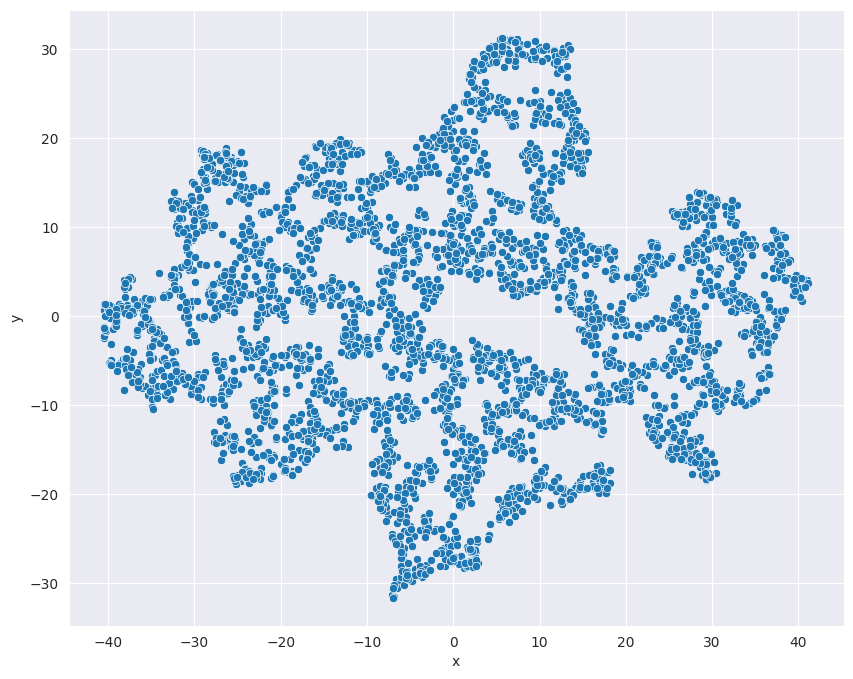

In [ ]:
# Get the scatter plot of svd item embeddings with 2-components

plt.figure(figsize=(10,8))
sns.scatterplot(data=projection, x='x',y='y')
plt.show()

In [ ]:
# Split the dataset based on rounded average ratings

R1 = projection.loc[projection['Avg_Rating'] == 1.0]
R2 = projection.loc[projection['Avg_Rating'] == 2.0]
R3 = projection.loc[projection['Avg_Rating'] == 3.0]
R4 = projection.loc[projection['Avg_Rating'] == 4.0]
R5 = projection.loc[projection['Avg_Rating'] == 5.0]

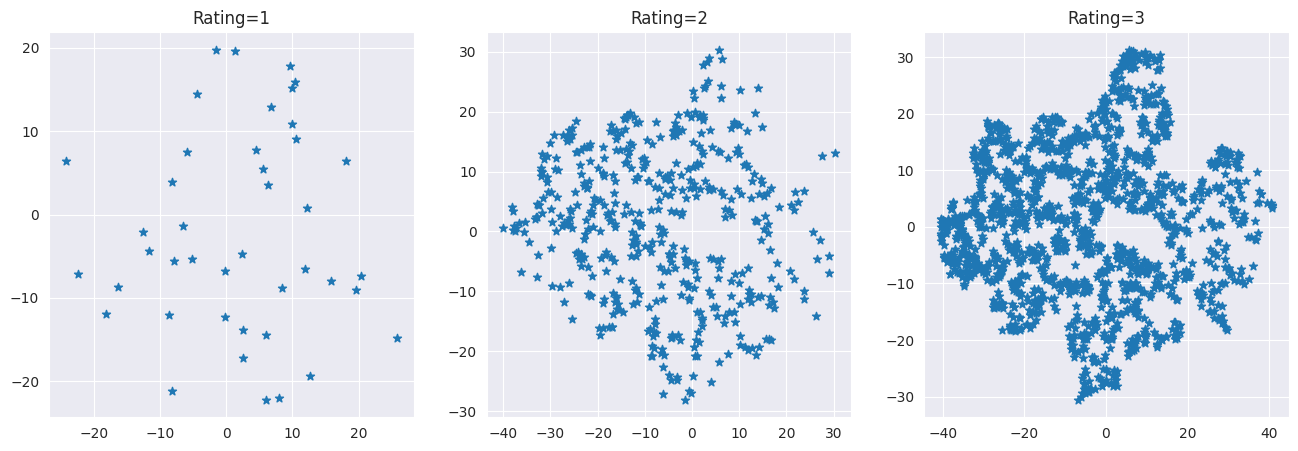

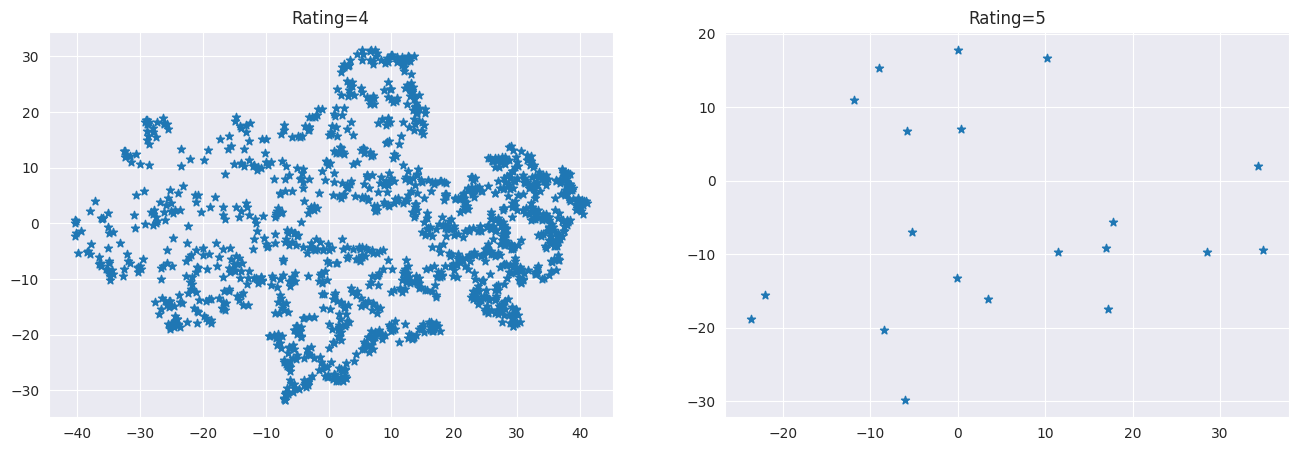

In [ ]:
# Plot each rating separately

plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.scatter(R1['x'], R1['y'],marker='*')
plt.title('Rating=1')
plt.subplot(1,3,2)
plt.scatter(R2['x'], R2['y'],marker='*')
plt.title('Rating=2')
plt.subplot(1,3,3)
plt.scatter(R3['x'], R3['y'],marker='*')
plt.title('Rating=3')
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(R4['x'], R4['y'],marker='*')
plt.title('Rating=4')
plt.subplot(1,2,2)
plt.scatter(R5['x'], R5['y'],marker='*')
plt.title('Rating=5')
plt.show()

#### Inference from 2-embeddings visualization of svd items
1. The plot seems to form a shape of 5 petal flower
2. The projections with 3-star ratings are the most dense
3. The second top dense plot is for the 4-star rating
4. The third top dense plot is for the 2-star rating
5. 1-star and 5-star ratings are quite sparse

In [ ]:
# Question 10 from questionaire

row = [0,1,1]
col = [0,0,1]
val = [1,3,7]
csr_matrix((val, (row, col)), shape=(2, 2)).toarray()

array([[1, 0],
       [3, 7]])

#### Observations and Recommendations

##### Observations
1. Pearson correlation works pretty well in this scenario
2. Cosine similarity also works pretty good for item-item and user-user recommendation
3. Questions from questionaire cover most of observations
4. Males are top contributors while watching and rating the movies
5. College/grad students are superusers of movie watching platform
6. Age group 25 are the top users of the movie watching platform
7. Comedy and Drama genres have the highest number of movies
8. Maximum number of movies are released in the 90s with 1999 and 1997 being the top contributor
9. Maximum number of movies watched or rated during the hour 3 and 8 (not sure of time zone)
10. Clusters with ratings 3 and 4 are highly densed

##### Recommendations
1. Pearson correlation and item similarity matrix based on cosine similarity works well. So business can use these models
2. To improve the accuracy of recommendation business can try to provide more metadata of movies and users
3. Business can think of adding more contents for different age groups other than age group 25
4. A good chunk of users are academic and educators, business can make sure to have enough contents for them.
5. Female users are less than half of the male users. Business can think of implementing some offers to female users to increase the registration on the platform